<a href="https://colab.research.google.com/github/racoope70/Credit-Card-Fraud-Detection/blob/main/stacking_and_hyperparameter_tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Step 1: Install necessary libraries if not already installed
!pip install xgboost imbalanced-learn
!pip uninstall -y scikit-learn imbalanced-learn
!pip install scikit-learn==1.1.3 imbalanced-learn==0.9.1


Found existing installation: scikit-learn 1.1.3
Uninstalling scikit-learn-1.1.3:
  Successfully uninstalled scikit-learn-1.1.3
Found existing installation: imbalanced-learn 0.9.1
Uninstalling imbalanced-learn-0.9.1:
  Successfully uninstalled imbalanced-learn-0.9.1
  Using cached scikit_learn-1.1.3-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (10 kB)
  Using cached imbalanced_learn-0.9.1-py3-none-any.whl.metadata (13 kB)
Using cached scikit_learn-1.1.3-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (32.0 MB)
Using cached imbalanced_learn-0.9.1-py3-none-any.whl (199 kB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 1.31.0 requires scikit-learn>=1.2.2, but you have scikit-learn 1.1.3 which is incompatible.
mlxtend 0.23.3 requires scikit-learn>=1.3.1, but you have scikit-learn 1.1.3 which is incompatible.
sklearn-comp

In [2]:

# Import necessary libraries
from imblearn.over_sampling import SMOTE, ADASYN
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import precision_recall_curve, confusion_matrix, classification_report, roc_auc_score
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import MinMaxScaler
from shap import TreeExplainer, summary_plot
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt

In [3]:
import pandas as pd
from google.colab import drive

# Step 3: Mount Google Drive
drive.mount('/content/drive')

# Load the uploaded Credit Card Fraud Detection dataset
file_path = '/content/drive/MyDrive/cleaned_creditcard_data.csv'
cleaned_creditcard_data = pd.read_csv(file_path)

# Display the first few rows of the dataset to understand its structure
cleaned_creditcard_data.head()


Mounted at /content/drive


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [4]:
import joblib

# Load resampled data
X_resampled, y_resampled = joblib.load('/content/drive/My Drive/X_y_resampled.pkl')
print("Resampled data loaded successfully.")

Resampled data loaded successfully.


In [5]:
# Load train/test split
X_train, X_test, y_train, y_test = joblib.load('/content/drive/My Drive/train_test_split.pkl')
print("Train/test split loaded successfully.")

Train/test split loaded successfully.


In [6]:
# Load the best model
best_model = joblib.load('/content/drive/My Drive/best_xgboost_model.pkl')
print("Best model loaded successfully.")

Best model loaded successfully.


Class Distribution After SMOTE + ADASYN: Counter({0: 226597, 1: 226597})


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [01:56:48] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


Confusion Matrix:
 [[56651     5]
 [   18    72]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     56656
           1       0.94      0.80      0.86        90

    accuracy                           1.00     56746
   macro avg       0.97      0.90      0.93     56746
weighted avg       1.00      1.00      1.00     56746


ROC-AUC Score: 0.9696201637955381

Best Threshold: 0.21838156004535522

Best Hyperparameters: {'xgb__n_estimators': 100, 'xgb__max_depth': 4, 'xgb__learning_rate': 0.01}


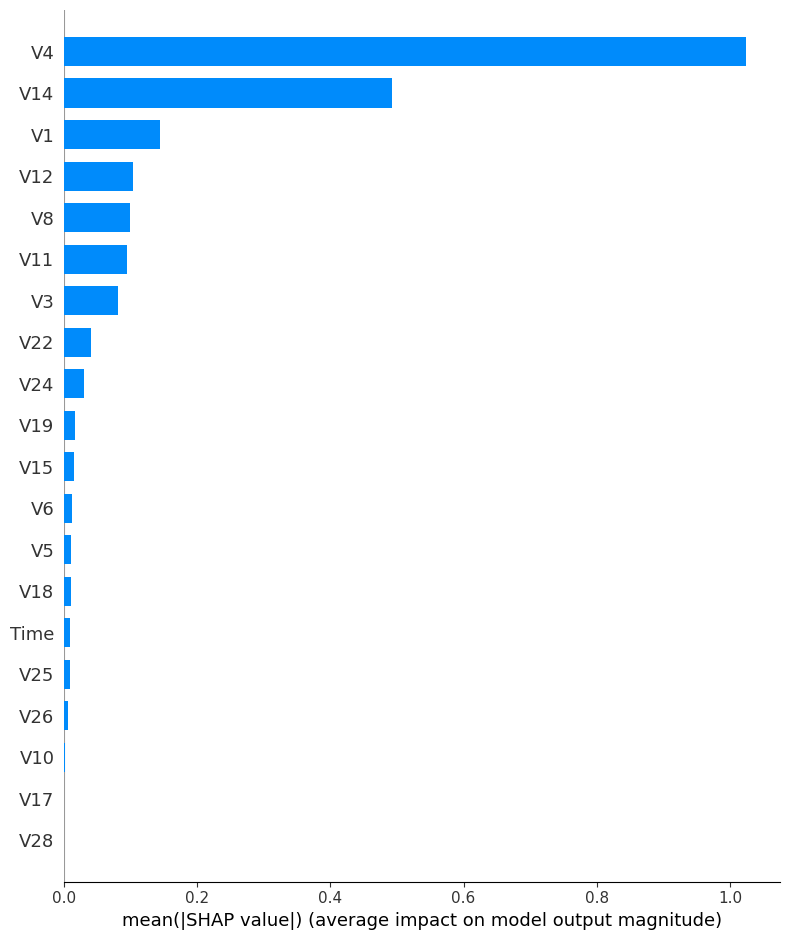

Model ready for real-time fraud detection with monitoring and drift detection.


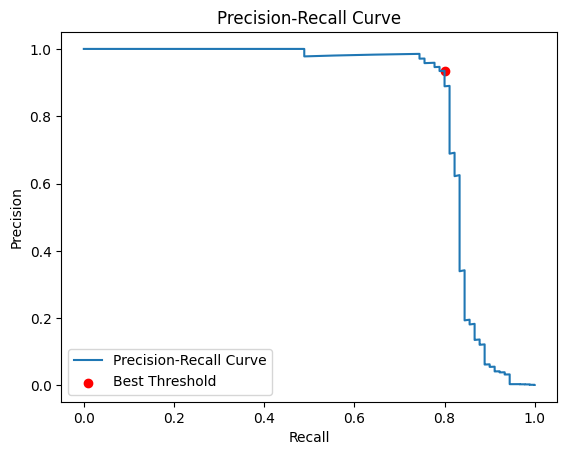

In [7]:


# Step 1: Data Preprocessing
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 2: Handle Class Imbalance (SMOTE + ADASYN)
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train_scaled, y_train)

adasyn = ADASYN(random_state=42)
X_resampled, y_resampled = adasyn.fit_resample(X_resampled, y_resampled)

# Verify the class distribution
print("Class Distribution After SMOTE + ADASYN:", Counter(y_resampled))

# Step 3: Define Base Models for Stacking
xgb_model = XGBClassifier(
    tree_method="hist",
    scale_pos_weight=len(y_train[y_train == 0]) / len(y_train[y_train == 1]),
    random_state=42,
    use_label_encoder=False,
    gpu_id=0,  # Use GPU
    predictor="gpu_predictor"
)

rf_model = RandomForestClassifier(random_state=42, n_jobs=-1)
lr_model = LogisticRegression(class_weight='balanced', random_state=42, solver='saga', max_iter=500)

# Step 4: Stacking Classifier
stacking_model = StackingClassifier(
    estimators=[
        ('xgb', xgb_model),
        ('rf', rf_model),
        ('lr', lr_model)
    ],
    final_estimator=LogisticRegression(random_state=42, max_iter=500),
    cv=3,
    n_jobs=-1
)

# Step 5: Hyperparameter Optimization for XGBoost
param_dist = {
    'xgb__max_depth': [4, 6, 8],
    'xgb__learning_rate': [0.01, 0.1, 0.2],
    'xgb__n_estimators': [100, 200, 300],
}

random_search = RandomizedSearchCV(
    estimator=stacking_model,
    param_distributions=param_dist,
    scoring='f1',
    n_iter=10,
    cv=StratifiedKFold(3),
    random_state=42,
    n_jobs=-1
)

# Fit the optimized model
random_search.fit(X_resampled, y_resampled)
best_model = random_search.best_estimator_

# Step 6: Predict probabilities on the test set
y_pred_prob = best_model.predict_proba(X_test_scaled)[:, 1]

# Step 7: Optimize Decision Threshold using Precision-Recall Curve
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_prob)
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-10)
best_threshold = thresholds[np.argmax(f1_scores)]

# Step 8: Predict labels with the optimized threshold
y_pred_custom = (y_pred_prob >= best_threshold).astype(int)

# Step 9: Evaluate the model
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_custom))
print("\nClassification Report:\n", classification_report(y_test, y_pred_custom))
print("\nROC-AUC Score:", roc_auc_score(y_test, y_pred_prob))
print("\nBest Threshold:", best_threshold)
print("\nBest Hyperparameters:", random_search.best_params_)

# Step 10: Explainability with SHAP
explainer = TreeExplainer(best_model.named_estimators_['xgb'])
shap_values = explainer.shap_values(X_test_scaled)
summary_plot(shap_values, X_test_scaled, plot_type="bar", feature_names=X_train.columns)

# Step 11: Real-Time Adaptation
# Placeholder for drift detection and retraining pipeline
print("Model ready for real-time fraud detection with monitoring and drift detection.")

# Visualize precision-recall curve
plt.plot(recall, precision, label='Precision-Recall Curve')
plt.scatter(recall[np.argmax(f1_scores)], precision[np.argmax(f1_scores)], color='red', label='Best Threshold')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.title('Precision-Recall Curve')
plt.show()


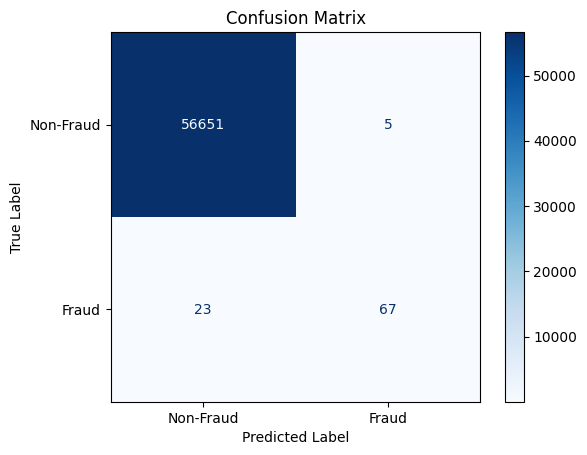

In [12]:
# Confusion Matrix Visualization
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred_custom)  # Use y_pred_custom for threshold-optimized predictions
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Non-Fraud', 'Fraud'])

# Plot the confusion matrix
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()
